
### Análise e modelo de agrupamento
> Expectativa de vida em 2025

---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


- Carregando os dados

In [2]:
FILE = './../data/overall_life_expectancy_2025.csv'
df = pd.read_csv(FILE)

- Estrutura dos dados

In [5]:
display(df.head(10))
display(df.info())
display(df.dtypes)

,id,country,expectancy,rounded_expectancy,continent
0,1,Monaco,86.6107,87,Europe
1,2,San Marino,85.9248,86,Europe
2,3,Hong Kong,85.7686,86,Asia
3,4,Japan,85.0012,85,Asia
4,5,Republic of Korea,84.5348,85,Asia
5,6,Saint Barthélemy,84.5153,85,North America
6,7,Andorra,84.3305,84,Europe
7,8,French Polynesia,84.3117,84,Oceania
8,9,Switzerland,84.2293,84,Europe
9,10,Australia,84.2135,84,Oceania


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  237 non-null    int64  
 1   country             237 non-null    object 
 2   expectancy          237 non-null    float64
 3   rounded_expectancy  237 non-null    int64  
 4   continent           237 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 9.4+ KB


None

id                      int64
country                object
expectancy            float64
rounded_expectancy      int64
continent              object
dtype: object

- Deletando a coluna de "expectancy", "id"

In [3]:
df.drop(['id', 'expectancy'], axis=1, inplace=True)

- Renomeando as colunas

In [4]:
df.columns = ['Pais', 'Expectativa_Vida', 'Continente']



- Média e desvio padrão por continente

In [6]:
std = df.groupby('Continente')['Expectativa_Vida'].std().sort_values(ascending=False)
mean = df.groupby('Continente')['Expectativa_Vida'].mean().sort_values(ascending=False)

df['STD_Continente'] = df.groupby('Continente')['Expectativa_Vida'].transform('std')
df['Media_Continente'] = df.groupby('Continente')['Expectativa_Vida'].transform('mean')

- Expectativa de vida por continente

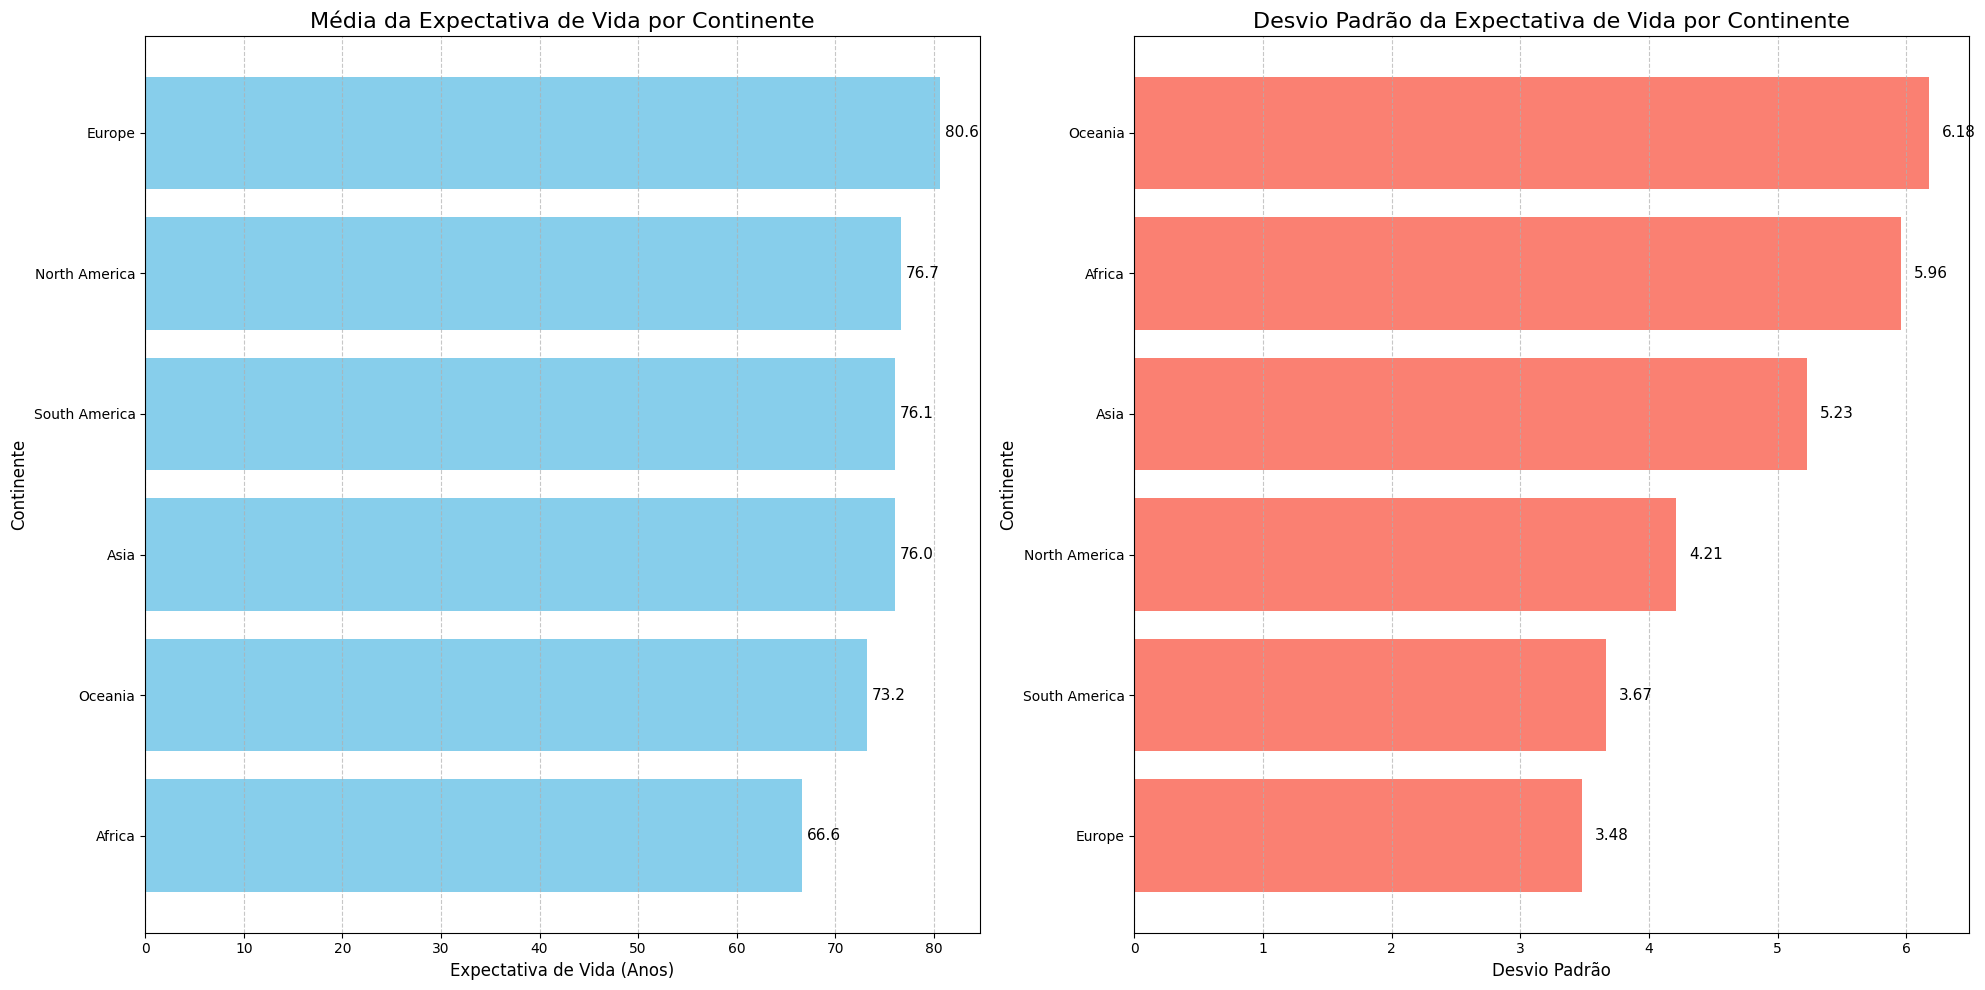

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

axes[0].barh(mean.index, mean.values, color='skyblue')
axes[0].set_title('Média da Expectativa de Vida por Continente', fontsize=16)
axes[0].set_xlabel('Expectativa de Vida (Anos)', fontsize=12)
axes[0].set_ylabel('Continente', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].invert_yaxis()  # mantém maior em cima
for i, v in enumerate(mean.values):
    axes[0].text(v + 0.5, i, f'{v:.1f}', va='center', fontsize=11)

axes[1].barh(std.index, std.values, color='salmon')
axes[1].set_title('Desvio Padrão da Expectativa de Vida por Continente', fontsize=16)
axes[1].set_xlabel('Desvio Padrão', fontsize=12)
axes[1].set_ylabel('Continente', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].invert_yaxis()  # mantém maior em cima
for i, v in enumerate(std.values):
    axes[1].text(v + 0.1, i, f'{v:.2f}', va='center', fontsize=11)

plt.tight_layout()
plt.savefig('./../fig/medidas_centrais_continente.png', dpi=300)
plt.show()


A Europa apresenta a maior média de expectativa de vida (~80,6 anos) e o menor desvio padrão 3,5. Isso mostra que, além de viverem mais, os países da região são mais homogêneos em termos de expectativa de vida.  

Já a África possui a menor média 66,6 anos e um dos maiores desvios padrões (~6,0). Ou seja, a população vive menos em média e há mais desigualdade entre os países africanos.  

Esse contraste evidencia bem a relação entre nível de desenvolvimento, saúde e desigualdade regional.


- Transformações das variaveis categoricas e numericas

In [13]:

processing = ColumnTransformer(
        transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Continente', 'Pais']),
        ('num', StandardScaler(), ['Expectativa_Vida', 'Media_Continente', 'STD_Continente'])
    ]
)

X = processing.fit_transform(df)


- Analisando a quantidade de clusters

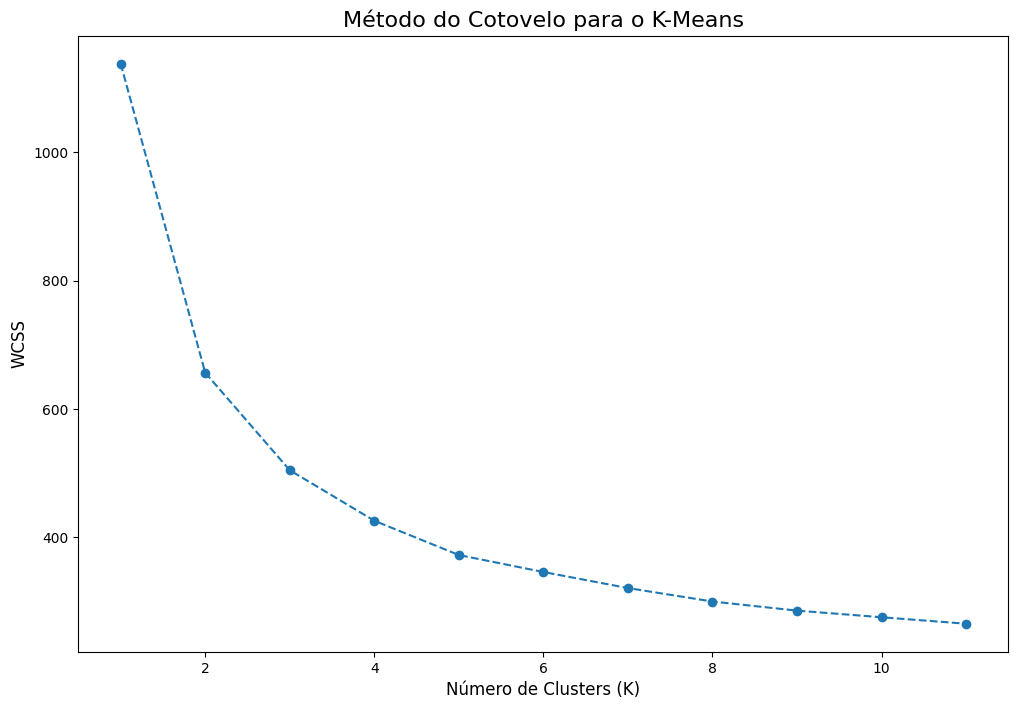

In [14]:
K = range(1,12)
wcss = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    wcss.append(kmeans.fit(X).inertia_)

plt.figure(figsize=(12, 8))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo para o K-Means', fontsize=16)
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.show()

> O número de clusters ideal esta entre 3 a 5 clusters

- Avaliando o score para cada modelo 

In [17]:
K = range(3, 6)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    label = kmeans.fit_predict(X)
    score = silhouette_score(X, label)
    print(f'Modelo com {k} clusters possui score de {score:.4f}')

Modelo com 3 clusters possui score de 0.3051
Modelo com 4 clusters possui score de 0.2909
Modelo com 5 clusters possui score de 0.3041


- Adicionando colunas com os clusters de cada modelo

In [18]:
for k in range(3, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    df[f'Modelo com {k}'] = kmeans.fit_predict(X) + 1

- Media da expectativa de vida para cada cluster de cada modelo

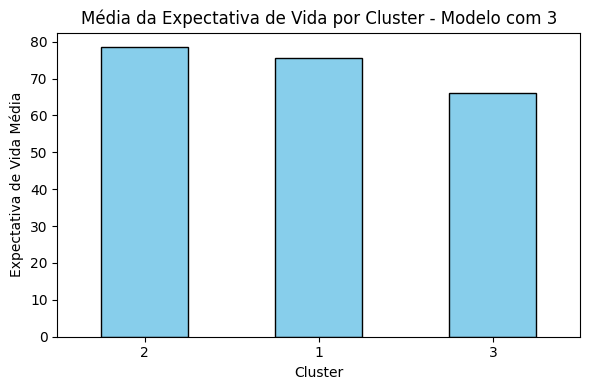

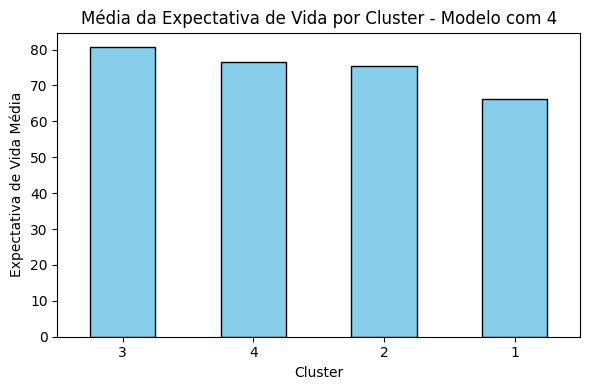

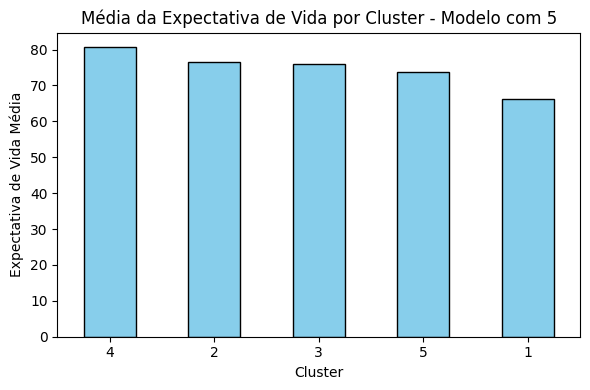

In [ ]:

columns = ['Modelo com 3', 'Modelo com 4', 'Modelo com 5']

for col in columns:
    mean = df.groupby(col)['Expectativa_Vida'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(6,4))
    mean.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title(f'Média da Expectativa de Vida por Cluster - {col}')
    plt.xlabel('Cluster')
    plt.ylabel('Expectativa de Vida Média')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


- Escolhendo o modelo com 3 clusters e deletando os demais

In [37]:
df.drop(['Modelo com 4', 'Modelo com 5'], axis=1, inplace=True)

- Exportando os dados

In [38]:
df.to_csv('./../data/expectativa_vida2025_cluster.csv', sep=';', index=False)

- Clusters de cada continente

In [41]:
continent_cluster = df.groupby('Modelo com 3')['Continente'].value_counts()
display(continent_cluster)

Modelo com 3  Continente   
1             Asia             51
              Oceania          22
              Africa            1
2             Europe           50
              North America    41
              South America    14
3             Africa           57
              Oceania           1
Name: count, dtype: int64

- Amostra dos paises por cluster

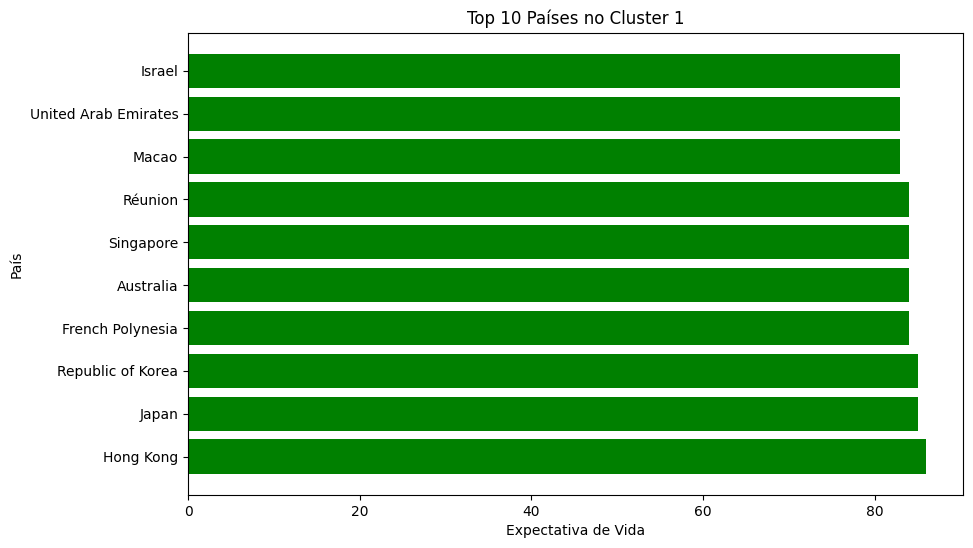

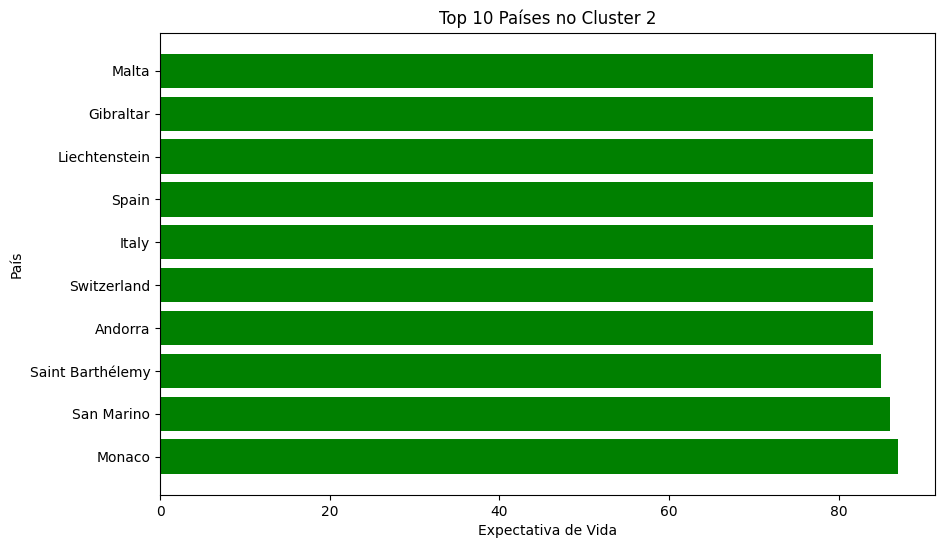

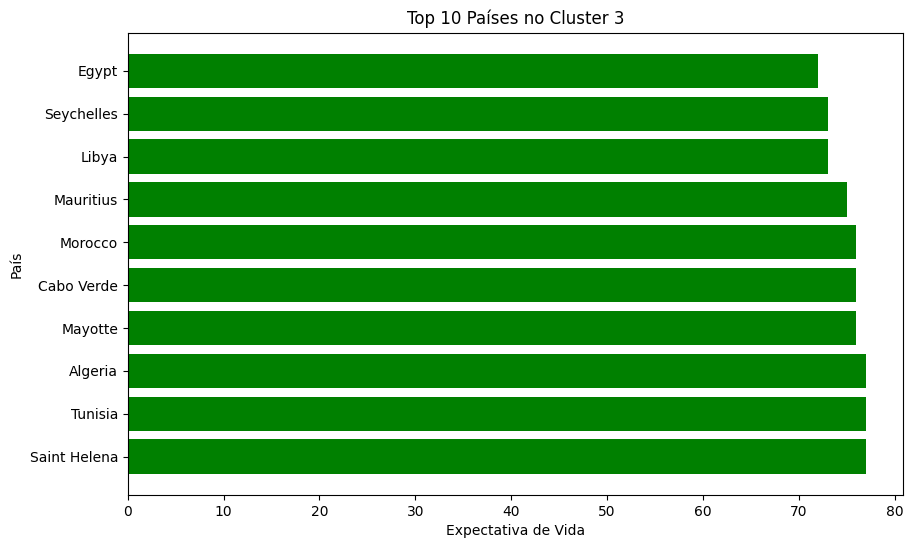

In [50]:


clusters = [1, 2, 3]

for c in clusters:
    query_cluster = df[df['Modelo com 3'] == c].sort_values(by='Expectativa_Vida', ascending=False).iloc[0:10]
    
    plt.figure(figsize=(10, 6))
    plt.barh(query_cluster['Pais'], query_cluster['Expectativa_Vida'], color='green')
    
    plt.title(f'Top 10 Países no Cluster {c}')
    plt.xlabel('Expectativa de Vida')
    plt.ylabel('País')
    plt.savefig(f'./../fig/grafico_do_cluster{c}.png', dpi=300)
    plt.show()


---

# ✅ Conclusão
O modelo de **3 clusters** discrimina bem os blocos globais de expectativa de vida:  

1. **Alta:** Europa + América do Norte + parte da América do Sul.  
2. **Intermediária:** Ásia + Oceania.  
3. **Baixa:** África (quase integralmente).  

Esse agrupamento confirma que **K=3 captura de forma clara a desigualdade global de expectativa de vida**, com separações consistentes entre continentes e níveis de desenvolvimento.
